<span style='margin-left: 100px;'><h1>Introducing PyGEM: Submission for [Google - AI Assistants for Data Tasks with Gemma](https://www.kaggle.com/competitions/data-assistants-with-gemma) Kaggle Competition
    
<span style='margin-left: 300px;'>![](https://i.imgur.com/CQQb5NH.png)
    
# What makes this submission unique?
1. A user-friendly and interactive way to ask questions to the chatbot
2. Quantifiable metrics beyond just human judgement of queries
3. Novel datasets used to train the model (in addition to other data sources)
4. Both RAG and fine-tuning demonstrated and implemented
    
# Description
This notebook showcases how Google's Gemma models can easily be used to create cost-effective and high-quality language models. A chatbot named "PyGEM" (a mix of "Python" and "Gemma") is designed to answer questions about the Python programming language. Along the way, the concepts of Retrieval-Augmented Generation (RAG), embedding models, large language model evaluation metrics, model fine-tuning with low-rank adaptation (LoRA), and interactive displays are discussed. Enjoy!
    
# Table of contents
1. [Retrieval-Augmented Generation (RAG)](#RAG)
    1. [Data Descriptions and Document Creation](#Create)
    2. [Embedding Model and Knowledge Base Construction](#Construct)
    3. [Context Retrieval and Prompt Engineering](#Engineer)
2. [Model Creation and Enabling Low Rank Adaptation (LoRA)](#Model)
3. [Evaluation Metrics before Fine-Tuning](#Metrics)
4. [Model Fine-Tuning and Re-Evaluation](#FT)
5. [Interactive Messaging and Displays](#UI)
6. [Conclusion and Limitations](#Conclusion)
7. [Screenshots of Notebook Output](#results)
    
To go straight to the final model with RAG and the function to ask the model questions (without interface, explanation of code, or calculation of evaluation metrics as done below), [click here](#MVP).


In [1]:
%%capture
#Install and import all required packages for the notebook

!pip install rouge-score
!pip install langchain langchain-openai faiss-cpu tiktoken
!pip install chromadb
!pip install sentence-transformers
!pip install PyPDF2
!pip install ipywidgets
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.vectorstores.chroma import Chroma
from PyPDF2 import PdfReader
import keras
import keras_nlp
import tensorflow as tf
from rouge_score import rouge_scorer
from langchain.embeddings import SentenceTransformerEmbeddings
import time
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import sentencepiece
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

#define the backend for model training
os.environ["KERAS_BACKEND"] = "jax"
#set to high fraction to help prevent memory fragmentation
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.00'

2024-04-23 22:49:17.436796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 22:49:17.436910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 22:49:17.562215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Retrieval-Augmented Generation (RAG) <a name="RAG"></a>

[Retrieval-Augmented Generation (RAG)](https://blogs.nvidia.com/blog/what-is-retrieval-augmented-generation/) is one techinque used to help prevent LLMs from hallucinating nonsense answers to questions a user may have. A RAG system may roughly be broken down into a few steps:

1. [**Document Gathering and Cleaning**](#Create) - Various potentially relevant documents to the task are gathered and then split into chunks of text.
2. [**Embedding Model and Knowledge Base Construction**](#Construct) - A (typically pre-trained) embedding model is selected that transforms the chunked text into [word embeddings](https://www.tensorflow.org/text/tutorials/word_embeddings). These embeddings are stored in a vector database.
3. [**Context Retrieval and Prompt Engineering**](#Engineer) - A query is embedded and then compared to all embeddings of chunked text in the knowledge base. The top k chunks are then fed to the model for additional context before answering a question. 

Each of the 3 steps are performed below.

## 1. Data Descriptions + Document Gathering and Cleaning<a name="Create"></a>

In [2]:
#This notebook cell defines various helper functions that we will use in the RAG system construction

def create_document(pdf_path,start_idx=None, end_idx=None):
    '''
    Extracts text from a pdf and Creates a Langchain Document object

    Parameters:
    pdf_path (str): File path of the pdf to be placed into knowledge base
    start_idx (int): Deletes the first n characters of the document if irrelavent
    end_idx (int): Deletes the last n characters of the document if irrelavent

    Returns:
    doc (Document): The pdf text as a Langchain Document Object
    '''
    text = ''
    #extract the text from the pdf
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        for page in reader.pages:
            text += page.extract_text()
            
    #if we know when relevant info for the doc starts and ends, cut off irrelevant parts
    if start_idx and end_idx:
        text=text[start_idx:end_idx]
    
    #create the document and record where the text came from
    doc = Document(page_content=text,metadata={"source":pdf_path})
      
    return doc

def split_text(documents: list[Document]):
    '''
    Converts Langchain Document objects into many smaller Document objects 
    of chunked text

    Parameters:
    documents (list[Document]): list of Langchain Document objects to be chunked

    Returns:
    chunks (list[Document]): chunked text as Langchain Document objects
    '''
    
    #define hyperparameters for how to split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        #number of characters per chunk
        chunk_size=300,
        #make chunks overlap to hopefully capture important info
        chunk_overlap=100,
        length_function=len,
        add_start_index=True,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")


    return chunks

def split_df_RAG(df,path,RAG_proportion=.5):
    '''
    To reduce training time, can place some of training set into RAG system
    and exclude from training. This function randomly transforms some
    observations into RAG Documents.

    Parameters:
    df (pd.DataFrame): dataFrame with <QUESTION> column and <RESPONSE> column
    path (str): location of data path for data in df
    RAG_proportion (float): percentage of observations to transfer to RAG

    Returns:
    doc (Langchain Document): Un-chunked Document for RAG
    df (pd.DataFrame): remaining observations to keep for training set
    '''
    
    #get random indices to keep for RAG
    random_indices = np.random.permutation(df.shape[0])
    RAG_idx = random_indices[:int(df.shape[0]*RAG_proportion)]
    #get corresponding training set indices
    remaining_idx = random_indices[int(df.shape[0]*RAG_proportion):]
    #convert RAG examples into a document
    RAG_examples = df.iloc[RAG_idx]
    RAG_text = (RAG_examples['<QUESTION>']+' \n' +RAG_examples['<RESPONSE>']).values
    RAG_text = ' '.join(RAG_text)
    doc = Document(page_content=RAG_text,metadata={"source":path})
    #remove the RAG examples from the training set
    df = df.iloc[remaining_idx]
    
    return doc,df

#### Data Sources:
1. python-code-questions.jsonl: novel dataset consisting of basic python code tasks and appropriate responses. Gathered using a combination of human-reviewed and AI-generated questions and responses.

2. Python_Conceptual_Questions.jsonl: novel dataset consisting of basic general python questions (with no code) and appropriate responses. Gathered using a combination of human-reviewed and AI-generated questions and responses.

3. python-codes-25k.jsonl (source: https://huggingface.co/datasets/flytech/python-codes-25k): database of instructions revolving around daily tasks and corresponding python code to generate a basic function to complete such tasks.

4. mbpp.jsonl (source: https://www.kaggle.com/datasets/mpwolke/mbppjsonl/data): crowdsourced database of basic python code questions and corresponding responses.

In [3]:
#For each of our 4 data sources, load the data and send 90% of it to the RAG system.
#By doing this, we can 1) still allow the model to access information regarding a vast
#amount of common questions that hopefully span a diverse set of prompts 2) speed up
#training-time 3) still have a large enough training set to craft response style and
#hopefully become better at answering questions outside of knowledge base

#first two data sources already just have <QUESTION> and <RESPONSE> columns
np.random.seed(1)
df1_path = '/kaggle/input/python-code-questions/python_code_questions.jsonl'
df1 = pd.read_json(df1_path, lines=True)
RAG1, df1 = split_df_RAG(df1,df1_path,.9)

df2_path = '/kaggle/input/python-conceptual-q/Python_Conceptual_Questions.jsonl'
df2 = pd.read_json(df2_path, lines=True)
RAG2, df2 = split_df_RAG(df2,df2_path,.9)

#last two datasets need same columns as first two
df3_path = '/kaggle/input/flytech-pythoncodes-25k-dataset/python-codes-25k.jsonl'
df3 = pd.read_json(df3_path, lines=True)
df3=df3[['instruction','output']]
df3.rename(columns={'instruction': '<QUESTION>', 'output': '<RESPONSE>'}, inplace=True)
RAG3, df3 = split_df_RAG(df3,df3_path,.9)

df4_path = '/kaggle/input/mbppjsonl/mbpp.jsonl'
df4 = pd.read_json(df4_path, lines=True)
df4=df4[['text','code']]
df4.rename(columns={'text': '<QUESTION>', 'code': '<RESPONSE>'}, inplace=True)
RAG4, df4 = split_df_RAG(df4,df4_path,.9)

#combine into one dataset
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

#### Textbook Sources for Knowledge Base:
1. **Introduction to Machine Learning with Python** - Andreas C. Müller & Sarah Guido. Source: https://www.nrigroupindia.com/e-book/Introduction%20to%20Machine%20Learning%20with%20Python%20(%20PDFDrive.com%20)-min.pdf

2. **Learning Python** - Mark Lutz. Source: https://cfm.ehu.es/ricardo/docs/python/Learning_Python.pdf

3. **Programming Python** - Mark Lutz. Source: http://bilal-qudah.com/mm/Programming%20Python%20Fourth%20Edition.pdf

In [4]:
#Load Documents for Knowledge Base
documents=[RAG1,RAG2,RAG3,RAG4]

start_time = time.time()
for dirname, _, filenames in os.walk('/kaggle/input/knowledge-base'):
    counter=0
    for filename in filenames:
        counter+=1
        print("Loading textbook number {}".format(counter))
        doc_path = os.path.join(dirname, filename)
        documents.append(create_document(doc_path))

#Split document into multiple objects
chunks = split_text(documents)
end_time = time.time()
print("\nElapsed time:", end_time-start_time, "seconds")

Loading textbook number 1
Loading textbook number 2
Loading textbook number 3
Split 7 documents into 92885 chunks.

Elapsed time: 74.79901957511902 seconds


## 2. Embedding Model and Knowledge Base Construction <a name="Construct"></a>
The [GIST embedding models](https://arxiv.org/abs/2402.16829) are a project funded by the Word Bank. The model class performs well on the [MTEB (Massive Text Embedding Benchmark) leaderboard](https://huggingface.co/spaces/mteb/leaderboard), yet are low in computational memory requirements, and are thus used in this notebook. The embedding model employed in this notebook is the "small" version within the model class. At the time of notebook model construction, the small version of GIST ranked 22nd on the leaderboard which measures embedding models on a wide array of tasks. 

In [5]:
#Use embedding model from HF 
embeddings = SentenceTransformerEmbeddings(model_name = "avsolatorio/GIST-small-Embedding-v0")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
%%capture
# #Create vector database to hold chunked text

# start_time = time.time()
# #Using Chroma db
# vectordb = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory='./vectordb')
# #When running in notebook, need to use .persist()
# vectordb.persist() 
# end_time = time.time()
# print("\nElapsed time:", end_time-start_time, "seconds")

#load chroma db instead of constructing it again (faster)
vectordb = Chroma(persist_directory="/kaggle/input/vectordb/kaggle/working/vectordb", embedding_function=embeddings)

# #save database for future into output folder. Use as .zip file. If created db instead of loading it, change path
!zip -r vectordb.zip /kaggle/input/vectordb/kaggle/working/vectordb

## 3. Context Retrieval and Prompt Engineering <a name="Engineer"></a>

The knowledge base in the RAG system enables the model to retrieve additional context to a question before answering the query. When a question is asked, chunks of text most similar to the query are retrieved and incorporated into a [prompt template](https://medium.com/@princekrampah/prompt-templates-in-langchain-248c015be3e0). Prompt templates are reproducible, consistent ways to ask a model questions, and they can be designed to reflect the desired style of responses. Below, the additional context for each question in the datasets is retrieved, and the prompt template encourages the model to use the context to aid in answering each question.

In [7]:
#Now that we have an embedding model, need to embed all of the queries in the training and testing datasets
all_context=[]

for row in range(df.shape[0]):
    #for memory purposes, grab only top relevant chunk
    all_context.append(vectordb.similarity_search_with_relevance_scores(df['<QUESTION>'][row],k=1)[0][0].page_content)
#create a new column in the dataset
df['<CONTEXT>']=all_context

In [8]:
#Separate the ground-truth response labels from the dataset
X = df.drop(columns=['<RESPONSE>'])
y = df['<RESPONSE>']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=600, random_state=100)

#Add context to training and testing sets 
X_train_with_RAG = list('<CONTEXT>:\n' + X_train['<CONTEXT>'] + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ X_train['<QUESTION>'] + '\n\n<RESPONSE>:\n'+y_train)
X_test_with_RAG = list('<CONTEXT>:\n' + X_test['<CONTEXT>'] + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ X_test['<QUESTION>'] + '\n\n<RESPONSE>:\n')
X_val_with_RAG = list('<CONTEXT>:\n' + X_val['<CONTEXT>'] + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ X_val['<QUESTION>'] + '\n\n<RESPONSE>:\n')
y_test = y_test.reset_index()
y_test = y_test['<RESPONSE>']
y_val = y_val.reset_index()
y_val = y_val['<RESPONSE>']

#to measure if RAG helps on its own, get same training set but without context from RAG
X_test_pre_RAG = X_test['<QUESTION>'].to_list()
y_test_list = y_test.tolist()
for idx in range(len(X_test_pre_RAG)):
    X_test_pre_RAG[idx] = "<QUESTION>:\n\n" + X_test_pre_RAG[idx] + "\n\n<RESPONSE>:\n"

# Model Creation and Enabling Low Rank Adaptation (LoRA)<a name="Model"></a>

Fine-tuning large language models can require massive amounts of computational resources. To overcome this challenge while still providing quality outputs, many modellers have used [Low Rank Adaptation (LoRA)](https://towardsdatascience.com/understanding-lora-low-rank-adaptation-for-finetuning-large-models-936bce1a07c6). Rather than update all weights in the model, the LoRA framework involves approximating the weight matrix updates using the product of low rank matrices. This effectively lowers the number of trainable parameters in the model.

In [9]:
#Load the Gemma model with specified hyperparameters

#set seed for reproducability
tf.random.set_seed(100)

#load the instruct version of Gemma
model = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")
#rank 16 LoRA
model.backbone.enable_lora(rank=16) 
#Only allow model to look back 305 characters for memory purposes
model.preprocessor.sequence_length = 375
#define the weight decay / learning-rate for the optimizer (AdamW is used for this notebook)
optimizer = keras.optimizers.AdamW(
    learning_rate=8.5e-4,
    weight_decay=0.0005,
    )

#Exclude layernorm and bias terms from decay to speed up training and reduce memory consumption
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

#compile the model by specifying the loss and other metrics we may want to track
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


# Evaluation Metrics before Fine-Tuning<a name="Metrics"></a>

It is imperative that some metric beyond human evaluation on a very small subset of responses is used to assess a model's response quality. This notebook includes the use of [ROUGE score](https://thepythoncode.com/article/calculate-rouge-score-in-python#rouge-score-a-premier-evaluation-metric). While often used in tasks beyond chatbot-related problems (such as text summarization), ROUGE score is one way to measure the similarity between generated responses to queries and the corresponding ground-truth labels. Three common variants are ROUGE-N, ROUGE-L, and ROUGE-S scores. 

Specifically, this notebook includes the use of ROUGE-L and ROUGE-N (N=2) scores. ROUGE-L is based on the maximum common subsequence that appears in both the response and true label, helping to quantify sentence similariy rather than similarity based on strict word-to-word matches. ROUGE-2 scores quantify the overalp of bigrams between the response and true label.

Put plainly, a ROUGE-2 recall of 0.3 means that 30% of the bigrams in the true label appear in the generated response. A ROUGE-2 precision of 0.3 means that 30% of the bigrams in the generated response appear in the true label. F-measure is a weighted mean of the precision and recall. F-measure is always between 0 and 1, and is only high if both precision and recall are high. 

In [10]:
def generate_test_set_responses(features_test):
    '''
    Get model's answers for queries listed in the test set for evaluation metrics

    Parameters:
    features_test (list): list of prompts to ask model

    Returns:
    responses (list): list of responses from model
    '''
    responses=[]
    #for each prompt in the list
    for idx in range(len(features_test)):
    #generate the response
        responses.append(model.generate(features_test[idx], max_length=512))
    #update user
        if(idx%100==0):
            print("Finished number {}".format(idx))
            
    #We don't need to return the question that is kept when calling model.generate()
    keyword_length = len("<RESPONSE>:\n")
    #for each of the responses
    for idx in range(len(responses)):
    #find where response begins, and start after "<RESPONSE>:\n" substring
        try:
            start_idx = responses[idx].index("<RESPONSE>:")
            responses[idx]=responses[idx][(start_idx+keyword_length):]       
        except:
            pass
            
    return responses

In [11]:
def get_rogue_metrics(y_hat,y_true,rouge_type):
    '''
    Calculate rogue score recall, precision, and f-measure for a given list 
    of model responses and ground-truth labels

    Parameters:
    y_hat (list): list of generated responses from model
    y_true (list): list of ground-truth response labels
    rouge_type (str): one of 'rougeL' or 'rougeN' where N is an integer

    Returns:
    all_recall (list): rogue score recall for each response, ground-truth label pair
    all_precision (list): rogue score precision for each response, ground-truth label pair
    all_f_measure (list): rogue score f-measure for each response, ground-truth label pair
    '''
    scorer = rouge_scorer.RougeScorer([rouge_type])
    all_recall = [scorer.score(y_hat[idx],y_true[idx])[rouge_type].recall for idx in range(len(y_hat))]
    all_precision = [scorer.score(y_hat[idx],y_true[idx])[rouge_type].precision for idx in range(len(y_hat))]
    all_f_measure = [scorer.score(y_hat[idx],y_true[idx])[rouge_type].fmeasure for idx in range(len(y_hat))]
    
    return all_recall, all_precision, all_f_measure

In [12]:
#assess the performance without RAG and without fine-tuning
y_hat_pre_RAG = generate_test_set_responses(X_test_pre_RAG)
recall_pre, precision_pre, f_measure_pre = get_rogue_metrics(y_hat_pre_RAG, y_test_list,'rougeL')

I0000 00:00:1713912854.691156      28 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713912854.765801      28 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Finished number 0
Finished number 100
Finished number 200
Finished number 300


In [13]:
print("Mean rogueL recall pre-RAG is {}".format(round(np.mean(recall_pre),3)))
print("Mean rogueL precision pre-RAG is {}".format(round(np.mean(precision_pre),3)))
print("Mean rogueL fmeasure pre-RAG is {}".format(round(np.mean(f_measure_pre),3)))

Mean rogueL recall pre-RAG is 0.144
Mean rogueL precision pre-RAG is 0.488
Mean rogueL fmeasure pre-RAG is 0.193


In [14]:
#assess the performance with RAG but without fine-tuning
y_hat_post_RAG = generate_test_set_responses(X_test_with_RAG)
recall_post, precision_post, f_measure_post = get_rogue_metrics(y_hat_post_RAG, y_test_list,'rougeL')

Finished number 0
Finished number 100
Finished number 200
Finished number 300


In [15]:
print("Mean rogueL recall post-RAG is {}".format(round(np.mean(recall_post),3)))
print("Mean rogueL precision post-RAG is {}".format(round(np.mean(precision_post),3)))
print("Mean rogueL fmeasure post-RAG is {}".format(round(np.mean(f_measure_post),3)))

Mean rogueL recall post-RAG is 0.21
Mean rogueL precision post-RAG is 0.429
Mean rogueL fmeasure post-RAG is 0.234


# Model Fine-Tuning and Re-Evaluation <a name="FT"></a>

It is common to [fine-tune](https://cloud.google.com/vertex-ai/generative-ai/docs/models/tune-models) pre-trained language models to achieve better performance at specific tasks. Widely speaking, while pre-trained models can learn general semantic understandings, exposing the model to information regarding specific domains can boost performance in that domain. Moreover, fine-tuning can aid in shaping the style of responses for the model. Below, the Gemma model is fine-tuned on data that was not incorporated into the RAG system. One would intuitively expect the corresponding ROUGE scores on held-out testing data to increase since the model is both exposed to more information about Python and exposed to the style of responses common from these datasets (assuming the held-out data has a similar "distribution" to the training data). However, such ROUGE scores can still act as an auditing tool to ensure model quality has not been worsened from an error in the codebase or a collapse in model training.

Below, an [adaptive learning rate](https://d2l.ai/chapter_optimization/lr-scheduler.html) is employed via a scheduler to hopefully achieve better optimization results. Additionally, the training is performed with [early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/), meaning the algorithm will terminate if a validation metric becomes worse over time. Note that the early stopping method below is fairly conservative; rather than stop training immediately when the validation metric gets worse, it allows for (sometimes long) fluctuations. Essentially, then, the early stopping implementation below simply acts as a safeguard against an unexpected and significant plummeting of model performance. 

In [16]:
def ask_query(query):
    '''
    Given a query, gather appropriate context and pass both into model
    to get a response

    Parameters:
    query (str): question to ask the model

    Returns:
    return_str (str): response from the model
    '''
    #for memory purposes, our model does not look back too many characters.
    #therefore, just grab top 1 chunk most relevant to query
    context = vectordb.similarity_search_with_relevance_scores(query,k=1)[0]
    
    #prompt engineering: add the conext to the question to make the prompt
    entire_query = '<CONTEXT>:\n' + context[0].page_content + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ query + '\n\n<RESPONSE>:\n'
    #feed into model
    return_str = model.generate(entire_query,max_length=512)
    #if there is a relevant document, tell the user where the context was located
    if context[1] > .7:
        return_str += '\n\nContext taken from '+ context[0].metadata['source'].rsplit('/', 1)[-1]
    else:
    #if no relevant documents, still keep in prompt but warn the user about this
        return_str += '\n\n Warning: No relevant context for question in database.'
    
    #only return the actual response (not the question and context too)
    return_str = return_str.rsplit('\n\n<RESPONSE>:\n', 1)[-1]
    return(return_str)

In [17]:
#train the model

#use early stopping to try and prevent overfitting
# early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4, restore_best_weights=False, mode = "max",start_from_epoch=2)

# # Define the learning rate scheduler
# reduce_lr = ReduceLROnPlateau(monitor='sparse_categorical_accuracy', mode = "max", factor=0.05, patience=1, min_lr=1e-6,threshold=.02,threshold_mode='rel')

# history = model.fit(X_train_with_RAG, epochs=3, batch_size=1, callbacks=[reduce_lr,early_stopping],validation_data=(X_val_with_RAG, y_val))

In [18]:
#if we are loading a model that is already fine-tuned, run the below line
model.backbone.load_lora_weights("/kaggle/input/fine-tuned-pygem-weights/PyGEM_lora_weights_all_saved.lora.h5")
#if we trained the model, save progress by running line below. Here we run the line to save to Kaggle output folder
model.backbone.save_lora_weights("/kaggle/working/PyGEM_lora_weights_all_saved.lora.h5")
#alternatively, can save the entire keras model
model.save('PyGEM.keras')

In [19]:
#assess the performance with RAG and with fine-tuning
y_hat = generate_test_set_responses(X_test_with_RAG)   
recall_ft, precision_ft, f_measure_ft = get_rogue_metrics(y_hat, y_test_list,'rougeL')

Finished number 0
Finished number 100
Finished number 200
Finished number 300


In [20]:
print("Mean rogueL recall post-Fine-Tuning is {}".format(round(np.mean(recall_ft),3)))
print("Mean rogueL precision post-Fine-Tuning is {}".format(round(np.mean(precision_ft),3)))
print("Mean rogueL fmeasure post-Fine-Tuning is {}".format(round(np.mean(f_measure_ft),3)))

Mean rogueL recall post-Fine-Tuning is 0.44
Mean rogueL precision post-Fine-Tuning is 0.433
Mean rogueL fmeasure post-Fine-Tuning is 0.405


In [21]:
#ROUGE-2 Scores
recall_pre_2, precision_pre_2, f_measure_pre_2 = get_rogue_metrics(y_hat_pre_RAG, y_test_list,'rouge2')
recall_post_2, precision_post_2, f_measure_post_2 = get_rogue_metrics(y_hat_post_RAG, y_test_list,'rouge2')
recall_ft_2, precision_ft_2, f_measure_ft_2 = get_rogue_metrics(y_hat, y_test_list,'rouge2')

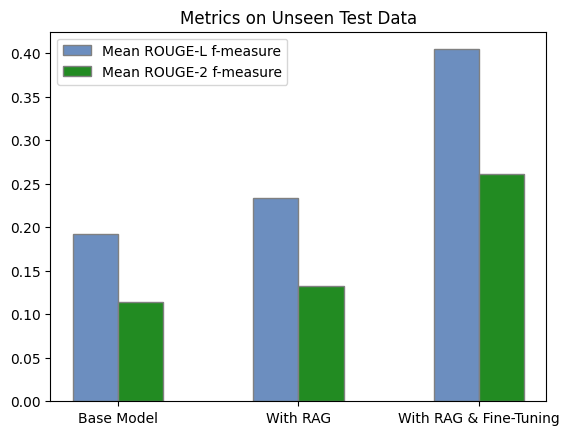

In [22]:
# Plot change in metrics after incorporating RAG and after fine-tuning
categories = ['Base Model', 'With RAG', 'With RAG & Fine-Tuning']
bars1 = [np.mean(f_measure_pre), np.mean(f_measure_post), np.mean(f_measure_ft)]
bars2 = [np.mean(f_measure_pre_2), np.mean(f_measure_post_2), np.mean(f_measure_ft_2)] 


r1 = np.arange(len(categories))
r2 = [x + 0.25 for x in r1]  # Adding 0.25 to each value in r1 to create space between bars
plt.bar(r1, bars1, color='#6c8ebf', width=0.25, edgecolor='grey', label='Mean ROUGE-L f-measure')
plt.bar(r2, bars2, color='#228B22', width=0.25, edgecolor='grey', label='Mean ROUGE-2 f-measure')
plt.xticks([r + 0.125 for r in range(len(categories))], categories)

plt.legend()
plt.title("Metrics on Unseen Test Data")
plt.show()

# Interactive Messaging and Displays <a name="UI"></a>

The [ipywidgets package](https://ipywidgets.readthedocs.io/en/stable/) can be used to create a user-friendly and appealing way to interact with models like PyGEM. This package enables one to create interactive "widgets" that can trigger functions to be called when an action (such as clicking a button) is performed. An alternative to this method is to build a [Dash app](https://dash.plotly.com/) and host a dashboard on an external server. Here, the ipywidgets package is used for simplicity.

In [23]:
# Define custom CSS style/preferences below

custom_css = """
/* Style for output area */
.output-area {
    margin-top: 20px;
    padding: 10px;
    background-color: #f0f0f0;
}

/* Style for loading spinner */
.spinner {
    border: 3px solid #f3f3f3; /* Light grey */
    border-top: 3px solid #3498db; /* Blue */
    border-radius: 50%;
    width: 30px; /* Adjust width */
    height: 30px; /* Adjust height */
    animation: spin 1s linear infinite; /* Apply animation */
    margin: auto;
    margin-top: 20px;
}

/* Keyframe animation for spinning */
@keyframes spin {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}
"""

# Apply custom CSS styles
display(HTML("<style>" + custom_css + "</style>"))

In [24]:
import ipywidgets
#Create text box so user can ask question
text_box = widgets.Text(
    value='',
    placeholder='Ask PyGEM your question here',
    description='Question:',
    disabled=False,
    layout=widgets.Layout(width='500px'),  
    style={'description_width': 'initial'}
)

#Create "Ask" button to submit query to model
submit_button = widgets.Button(
    description='Ask',
    disabled=False,
    button_style='success',
    tooltip='Ask'
)

output_area = widgets.Output()

#Define response function
def respond_to_question(sender):
    question = text_box.value
    
    text_box.value = ''
    
    #Display loading spinner while model is generating a response
    with output_area:
        output_area.clear_output()
        display(HTML('<div class="spinner"></div>'))
    
    #Generate the model's response
    response = ask_query(question)
    
    #Display the model's response to the user
    with output_area:
        output_area.clear_output()
        print(f"Question: {question}\n")
        print(f"Response: {response}\n")
        
#Assign response function to button click event
submit_button.on_click(respond_to_question)

#Define PyGEM logo
image_path = '/kaggle/input/pygem-logo/logo1.png'
image_widget = widgets.Image(value=open(image_path, 'rb').read(), format='png', width=400)

#Define PyGEM's intro
text_widget = widgets.HTML(
    value="<h2> <span style='margin-left: 100px;'>Hi! My name is PyGEM.<br><br> I was trained using Google's Gemma models to<br> answer any questions you have about the Python<br> programming language. Ask away!</h2>",
    layout=widgets.Layout(margin='25px 0') 
)

#Display everything
container = widgets.VBox([image_widget,text_widget,widgets.HBox([text_box, submit_button]), output_area],)
display(container)

# Conclusions <a name="Conclusion"></a>

1. **Quantifiably increased performance**: By incorporating RAG into the pre-trained Gemma model, the average ROGUE-L f-measure score for unseen data increased by a total of .02 to .03. Moreover, by also performing fine-tuning with existing and novel datasets, the f-measure score almost doubled to a total of 0.4. Similarly, the ROUGE-2 scores followed the same trajectory. With these concrete, quantifiable metrics combined with human evaluation on a few prompts, the increased performance and usability of the PyGEM model becomes clear. 
2. **Interpretability and Interactive Usage**: Via the RAG system, context from source documents is fed to the model along with the given prompt to form a response. The RAG system details which document contained the given context (and also warns the user if no relevant chunk of text is found), increasing interpretability. Moreover, the PyGEM model can be employed with a more user-friendly interface thanks to ipywidgets.
3. **Computational Ease**: Due to the lightweight nature of Gemma models, the PyGEM model was easily created with limited computational resources. Fine-tuning the model via ten epochs with a dataset of around 2000 prompts on a single P100 GPU took less than 3 hours.

# Limitations
1. **Context Window**: Due to memory allocation concerns, the pre-processor for PyGEM has maximum sequence length of 375. This results in the model being limited in how far back it can "look" in the conversation/prompt before providing an answer. Consequently, the chunks for RAG needed to remain relatively small as well (potentially lowering the quality of the retrieved chunks).
2. **Coding vs. Conceptual**: A primary goal for PyGEM was its versatility in being able to answer coding questions as well as general conceptual questions about Python. If one desired to build a model to solely aid in coding questions, for example, the training dataset would be more curated for this specific purpose.
3. **Heuristic for RAG Warning**: There is no exact, systematic method for picking a similarity threshold in RAG for when to warn a user if a relevant document is not found. The threshold can be chosen according to how high-stakes the application is or based off of an empirical distribution of similarities gathered via model deployment.


### To go straight to the final model with RAG and the function to ask the model questions (without interface, explanation of code, or calculation of evaluation metrics as done below), can uncomment and run the cell below <a name="MVP"></a>

In [25]:
# ###########LOAD DEPENDENCIES###########
# !pip install langchain langchain-openai faiss-cpu tiktoken
# !pip install chromadb
# !pip install sentence-transformers

# import numpy as np
# import pandas as pd
# from langchain.vectorstores.chroma import Chroma
# import keras
# import keras_nlp
# import tensorflow as tf
# from langchain.embeddings import SentenceTransformerEmbeddings
# import sentencepiece

# ###########GET EMBEDDING MODEL FOR RAG###########
# embeddings = SentenceTransformerEmbeddings(model_name = "avsolatorio/GIST-small-Embedding-v0")

# ###########LOAD RAG DATABASE###########
# vectordb = Chroma(persist_directory="/kaggle/input/vectordb/kaggle/working/vectordb", embedding_function=embeddings)

# ###########LOAD GEMMA MODEL###########
# model = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")
# #rank 16 LoRA
# model.backbone.enable_lora(rank=16) 
# #Only allow model to look back 300 characters for memory purposes
# model.preprocessor.sequence_length = 375
# #define the weight decay / learning-rate for the optimizer (AdamW is used for this notebook)
# optimizer = keras.optimizers.AdamW(
#     learning_rate=8.5e-4,
#     weight_decay=0.00025,
#     )

# #Exclude layernorm and bias terms from decay to speed up training and reduce memory consumption
# optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# #compile the model by specifying the loss and other metrics we may want to track
# model.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=optimizer,
#     weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )


# ###########LOAD LORA WEIGHTS FROM PREVIOUS TRAINING###########
# model.backbone.load_lora_weights("/kaggle/input/fine-tuned-pygem-weights/PyGEM_lora_weights_all_saved.lora.h5")

# ###########DEFINE FUNCTION TO ASK MODEL QUESTIONS###########
# def ask_query(query):
#     '''
#     Given a query, gather appropriate context and pass both into model
#     to get a response

#     Parameters:
#     query (str): question to ask the model

#     Returns:
#     return_str (str): response from the model
#     '''
#     #for memory purposes, our model does not look back too many characters.
#     #therefore, just grab top 1 chunk most relevant to query
#     context = vectordb.similarity_search_with_relevance_scores(query,k=1)[0]
    
#     #prompt engineering: add the conext to the question to make the prompt
#     entire_query = '<CONTEXT>:\n' + context[0].page_content + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ query + '\n\n<RESPONSE>:\n'
#     #feed into model
#     return_str = model.generate(entire_query,max_length=512)
#     #if there is a relevant document, tell the user where the context was located
#     if context[1] > .7:
#         return_str += '\n\nContext taken from '+ context[0].metadata['source'].rsplit('/', 1)[-1]
#     else:
#     #if no relevant documents, still keep in prompt but warn the user about this
#         return_str += '\n\n Warning: No relevant context for question in database.'
    
#     #only return the actual response (not the question and context too)
#     return_str = return_str.rsplit('\n\n<RESPONSE>:\n', 1)[-1]
#     return(return_str)


# ###########ASK QUESTION WITHOUT USER INTERFACE###########

# ask_query("What is Python?")
# #add other questions here if desired

# Screenshots of Final Results <a name="results"></a>

## Example 1
![](https://imgur.com/j4qjLY6.png)
## Example 2
![](https://imgur.com/RbxvJ4d.png)
## Example 3
![](https://imgur.com/MuYcwts.png)
## Numerical Results
![](https://imgur.com/XAXlzbT.png)